# Imports

In [2]:
# basics 
from watermark import watermark
import pandas  as pd
pd.options.display.float_format = '{:,.2f}'.format
import joblib
import numpy  as np
import optuna

# plot
import matplotlib.pyplot as plt
import plotly.express    as px
import seaborn           as sns

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# encoders
from category_encoders       import OneHotEncoder,TargetEncoder,BinaryEncoder


# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold


In [3]:
print( watermark( packages = 'pandas,seaborn,joblib,numpy,optuna,matplotlib,sklearn,category_encoders,xgboost,lightgbm' ) )

pandas           : 2.1.4
seaborn          : 0.13.2
joblib           : 1.4.2
numpy            : 1.26.4
optuna           : 4.2.1
matplotlib       : 3.10.0
sklearn          : 1.5.2
category_encoders: 2.6.3
xgboost          : 1.7.6
lightgbm         : 4.6.0



### 0.0 - Functions

In [4]:
# convert lat long into km's
from geopy.distance import geodesic

def encoding_training_data( df, y):

    dict_encoders = {}
    
    df_cat = df.select_dtypes(include=['object']).columns
    
    unique_count = df[df_cat].nunique() 
    
    df_aux = pd.DataFrame(unique_count).reset_index().rename(columns = {'index': 'category', 0: 'count'})

    for line in df_aux.iterrows():

        # applying one hot encoding
        if line[1]['count'] >=2 and line[1]['count'] <=6:

            ohe = OneHotEncoder(handle_unknown='value')

            ohe_trained = ohe.fit( df[ [ line[1]['category'] ] ])

            joblib.dump(ohe_trained, f'encoders/ohe_trained{line[1]['category']}.pkl')

            df_ohe = ohe_trained.transform( df[ [ line[1]['category'] ] ] ) 

            df = pd.concat( [df, df_ohe] , axis = 1 ).drop( line[1]['category'], axis = 1 )
            
            print(f'One Hot Encoding columns applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'OneHotEncoder'

        # applying target encoding
        if line[1]['count'] >=10 and line[1]['count'] <=60:

            te = TargetEncoder(handle_unknown='value')

            te_trained = te.fit( df[ [ line[1]['category'] ] ] , y = y )

            joblib.dump(te_trained, f'encoders/te_trained{line[1]['category']}.pkl')

            df[ line[1]['category'] ] = te_trained.transform( df[ [ line[1]['category'] ] ] ) 

            print( f'Target Enconding applied to: {line[1]['category']} column that has {line[1]['count']} values.' )

            dict_encoders[line[1]['category']] = 'TargetEncoder'

        # applying frequency encoding
        if line[1]['count'] >=60:

            category_counts = df[ line[1]['category'] ].value_counts()

            df[ line[1]['category'] ] =  df[ line[1]['category'] ].map( category_counts )

            joblib.dump(category_counts, f'encoders/category_counts{line[1]['category']}.pkl')

            print(f'Frequency Encoding applied to: {line[1]['category']} column that has {line[1]['count']} values.')

            dict_encoders[line[1]['category']] = 'category_counts'
            
    return df.select_dtypes(exclude = ['datetime']), dict_encoders

def feature_engineering(df):

    #df = df.sort_values(by = ['trans_date_trans_time','cc_num'], ascending = True)
    
    df['trans_date_trans_time'] = pd.to_datetime( df['trans_date_trans_time']  )

    df['dob'] = pd.to_datetime( df['dob'] )

    # extract year
    df['trans_date_trans_time_year'] = df['trans_date_trans_time'].dt.year

    # extract month
    df['trans_date_trans_time_month'] = df['trans_date_trans_time'].dt.month

    # extract day
    df['trans_date_trans_time_day'] = df['trans_date_trans_time'].dt.day

    # convert into datetime format
    df['dob'] = pd.to_datetime(df['dob'])

    # extract year from dob
    df['dob_year'] = df['dob'].dt.year
    
    # extract month from dob
    df['dob_month'] = df['dob'].dt.month

    # extract day from dob
    df['dob_day'] = df['dob'].dt.day

    # time_diff_seconds
    df['time_diff_seconds'] = (df['trans_date_trans_time'] - df['trans_date_trans_time'].shift()).dt.total_seconds()

    # total_spent_by_cc
    df['total_spent_by_cc'] = df.groupby('cc_num')['amt'].transform('sum')

    # trans_last_hour
    df['trans_last_hour'] = df.groupby('cc_num')['trans_date_trans_time'].transform(lambda x: (x - x.max()).dt.total_seconds() < 3600).sum()

    # avg_transaction_amount
    df['avg_transaction_amount'] = df.groupby('cc_num')['amt'].transform('mean')

    # location_distance
    df['location_distance'] =df.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km, axis=1)

    # transactions_per_location
    df['transactions_per_location'] = df.groupby(['merch_lat', 'merch_long'])['trans_num'].transform('count')

    # age
    df['age'] = (pd.to_datetime('today') - pd.to_datetime(df['dob'])).dt.days // 365

    # amt_to_avg
    df['amt_to_avg'] = df['amt'] / df['avg_transaction_amount']
    
    # unique_locations
    df['unique_locations'] = df.groupby('cc_num')['merch_lat'].transform('nunique')

    # most_frequent_category
    df['most_frequent_category'] = df.groupby('cc_num')['category'].transform(lambda x: x.mode()[0])

    # transactions_per_day
    df['transactions_per_day'] = df.groupby(df['trans_date_trans_time'].dt.date)['trans_num'].transform('count')

    # category_diversity
    df['category_diversity'] = df.groupby('cc_num')['category'].transform('nunique')

    # category_spending_deviation
    df['category_spending_deviation'] = df.groupby('category')['amt'].transform(lambda x: (x - x.mean()).abs())
    
    # night_transactions
    df['night_transactions'] = df['trans_date_trans_time'].dt.hour.between(0, 6).astype(int)

    # merchant_transactions
    df['merchant_transactions'] = df.groupby('merchant')['trans_num'].transform('count')

    df = df.drop( ['Unnamed: 0','trans_num'], axis = 1 )

    df = df.fillna(0)


    return df
    
def encoding_test_data(df, enconding_map ):

    test_cat_columns = df.select_dtypes( include = 'object' ).columns

    for chave,valor in enconding_map.items():
        
        if valor == 'category_counts':

            print(f'encodar como {valor} a coluna {chave}')
    
            fe_trained = joblib.load( f'encoders/category_counts{chave}.pkl' )
            
            df[chave] = df[chave].map( fe_trained )

        if valor == 'TargetEncoder':

            print(f'encodar como {valor} a coluna {chave}')
    
            te_trained = joblib.load( f'encoders/te_trained{chave}.pkl' )
    
            df[chave] = te_trained.transform( df[chave] )

        if valor == 'OneHotEncoder':

            print(f'encodar como {valor} a coluna {chave}')
    
            ohe = joblib.load( f'encoders/ohe_trained{chave}.pkl' )
    
            df_ohe = ohe.transform( df[chave] )

            df = pd.concat( [df, df_ohe], axis = 1 )

           
    df = df.fillna(0)

    return df.drop( 'gender', axis = 1 ).select_dtypes( exclude = ['datetime'] ) 

        
def eveluate_model(model_name, y_test, y_pred, y_pred_proba):

    df_result = pd.DataFrame()

    accuracy = accuracy_score(y_test, y_pred)

    precision = precision_score( y_test , y_pred )

    recall = recall_score( y_test , y_pred )

    f1 = f1_score( y_test , y_pred,average='binary' )

    if y_pred_proba.ndim == 2:
        roc = roc_auc_score(y_test, y_pred_proba[:, 1])  # Usando a probabilidade da classe positiva
    else:
        roc = roc_auc_score(y_test, y_pred_proba)


    dict_results = {'Model Name': model_name,
     'Accuracy_score': accuracy,
     'Precision_score': precision,
     'Recall': recall,
     'F1_score': f1,
     'ROC_AUC' : roc
    }

    return pd.DataFrame( dict_results, index = [0] )
    
        
def evaluate_model_cv(model, X, y, cv=5):


    tscv = TimeSeriesSplit(n_splits=cv)

    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    

    for train_index, val_index in tscv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    
        model.fit(X_train, y_train)
    
    
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred,average='binary' ))
        if y_pred_proba.ndim == 2:
            roc = roc_auc_score(y_val, y_pred_proba[:, 1])  # Usando a probabilidade da classe positiva
        else:
            roc = roc_auc_score(y_val, y_pred_proba)
    
    
    results = {
        'Model Name': str(model),
        'Accuracy_score': np.mean(accuracy_scores),
        'Precision_score': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1_score': np.mean(f1_scores),
        'ROC_AUC': np.mean(roc_auc_scores)
    }
    
    
    return pd.DataFrame(results, index=[0])


## 1 - Load Data

In [47]:
df = pd.read_csv( r'data/fraudTrain.csv' )
df_test = pd.read_csv(r'data/fraudTest.csv')
df.head().to_csv('sample.data.csv') 

## 2 - Check Data

In [6]:
df2 = df.copy()

### 2.1 - Check Shape

In [7]:
print(f'Dataset has {df2.shape[0]:,.2f} rows and {df2.shape[1]:,} columns')

Dataset has 1,296,675.00 rows and 23 columns


## 3.0 - Split Data Into Train and Test

In [8]:
df3 = df2.copy()

# converto to datetime format
df3['trans_date_trans_time'] = pd.to_datetime(df3['trans_date_trans_time'])
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'])

# order df by customer account and datetime in ascending order 
df3 = df3.sort_values( by = ['cc_num','trans_date_trans_time'], ascending = True )
df_test = df_test.sort_values(by = ['cc_num','trans_date_trans_time'],ascending = True)

In [9]:
# min date val
min_date = pd.to_datetime(df_test['trans_date_trans_time']).min() + pd.Timedelta(days=1)

# max date val
max_date_df_test = pd.to_datetime(df_test['trans_date_trans_time']).max()

# max date train val
max_date_val = max_date_df_test - pd.DateOffset(months=3)



In [10]:
# split data into X_train
X_train = df3.drop('is_fraud', axis = 1)

# y_train
y_train = df3['is_fraud']

# X_val
X_val = df_test.loc[ ( df_test['trans_date_trans_time'] >= min_date ) & (df_test['trans_date_trans_time'] <= max_date_val), : ]

# y val
y_val = X_val['is_fraud']

# drop y
X_val = X_val.drop('is_fraud', axis = 1)

print(f'Train dataset:\n min date:{X_train['trans_date_trans_time'].min()} | max date :{X_train['trans_date_trans_time'].max()}')
print(f'Positive class: {y_train.value_counts()[1]:,.2f} negative class: {y_train.value_counts()[0]:,.2f} ')
print('='*100)
print(f'Val dataset:\n min date:{X_val['trans_date_trans_time'].min()} | max date :{X_val['trans_date_trans_time'].max()}')
print(f'Val class: {y_val.value_counts()[1]:,.2f} negative class: {y_val.value_counts()[0]:,.2f} ')

Train dataset:
 min date:2019-01-01 00:00:18 | max date :2020-06-21 12:13:37
Positive class: 7,506.00 negative class: 1,289,169.00 
Val dataset:
 min date:2020-06-22 12:14:42 | max date :2020-09-30 23:59:23
Val class: 1,191.00 negative class: 269,359.00 


## 4 - Feature Engineering

In [11]:
X_train = feature_engineering(X_train)

X_val = feature_engineering(X_val)

## 5 - Encoding

In [12]:
X_train, enconding_map = encoding_training_data(X_train,y_train)

Frequency Encoding applied to: merchant column that has 693 values.
Target Enconding applied to: category column that has 14 values.
Frequency Encoding applied to: first column that has 352 values.
Frequency Encoding applied to: last column that has 481 values.
One Hot Encoding columns applied to: gender column that has 2 values.
Frequency Encoding applied to: street column that has 983 values.
Frequency Encoding applied to: city column that has 894 values.
Target Enconding applied to: state column that has 51 values.
Frequency Encoding applied to: job column that has 494 values.
Target Enconding applied to: most_frequent_category column that has 10 values.


In [13]:
X_val = encoding_test_data(X_val, enconding_map)

encodar como category_counts a coluna merchant
encodar como TargetEncoder a coluna category
encodar como category_counts a coluna first
encodar como category_counts a coluna last
encodar como OneHotEncoder a coluna gender
encodar como category_counts a coluna street
encodar como category_counts a coluna city
encodar como TargetEncoder a coluna state
encodar como category_counts a coluna job
encodar como TargetEncoder a coluna most_frequent_category


## 6 - Hyperparameter Fine Tuning

In [14]:
# calculate scale_pos_weight
n_negative = y_train.value_counts()[0]
n_positive = y_train.value_counts()[1]
scale_pos_weight = n_negative / n_positive
print(scale_pos_weight)

171.75179856115108


In [15]:
def objective(trial):
    param = {
        'objective': 'binary', 
        'metric': 'binary_error',  
        'boosting_type': 'gbdt', 
        'verbosity': -1, 
        'num_leaves': trial.suggest_int('num_leaves', 30, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 1.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3,scale_pos_weight),
    }

    # training the model
    model = lgb.LGBMClassifier(**param)
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_val)
    
    # calculating f1-score
    f1 = f1_score(y_val, y_pred)
    
    return f1

# creating optuna study
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=10)

# best params
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# training model with best params
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# final pred
final_y_pred = final_model.predict(X_val)
final_f1 = f1_score(y_val, final_y_pred)
print(f'Final F1-score: {final_f1}')


[I 2025-03-15 16:20:49,556] A new study created in memory with name: no-name-bd52a993-babd-43c6-91a4-048c1a9ada3d
[I 2025-03-15 16:22:47,131] Trial 0 finished with value: 0.29980563654033043 and parameters: {'num_leaves': 157, 'max_depth': 9, 'learning_rate': 0.15156619727519746, 'n_estimators': 997, 'subsample': 0.6034696570869336, 'colsample_bytree': 0.7262671203448047, 'min_child_samples': 57, 'lambda_l1': 0.35499794440074095, 'lambda_l2': 0.8338300343649537, 'scale_pos_weight': 118.1583757411904}. Best is trial 0 with value: 0.29980563654033043.
[I 2025-03-15 16:23:06,988] Trial 1 finished with value: 0.21016508996475608 and parameters: {'num_leaves': 190, 'max_depth': 4, 'learning_rate': 0.0440729217268274, 'n_estimators': 220, 'subsample': 0.6535986054363772, 'colsample_bytree': 0.7382047354711816, 'min_child_samples': 67, 'lambda_l1': 0.3372351785245249, 'lambda_l2': 0.06386364559343916, 'scale_pos_weight': 123.91114149507199}. Best is trial 0 with value: 0.29980563654033043.
[I

Best hyperparameters:  {'num_leaves': 208, 'max_depth': 8, 'learning_rate': 0.07586165309324866, 'n_estimators': 468, 'subsample': 0.9237770060458876, 'colsample_bytree': 0.6760679365558184, 'min_child_samples': 69, 'lambda_l1': 0.17031841843762263, 'lambda_l2': 0.40211397434023255, 'scale_pos_weight': 42.56032222118709}
Final F1-score: 0.6372819100091828


In [16]:
# exporting trained model
joblib.dump(final_model, 'model/final_model_v2.pkl')

['model/final_model_v2.pkl']

## Feature Selection

In [17]:
X_train = X_train.fillna(0)

In [18]:
best_params = {'num_leaves': 210,
               'max_depth': 6, 
               'learning_rate': 0.031848689347613535,
               'n_estimators': 684,
               'subsample': 0.6156461555507093,
               'colsample_bytree': 0.8845570949493153,
               'min_child_samples': 23,
               'lambda_l1': 0.25260756669271045,
               'lambda_l2': 0.14410813797453115,
               'scale_pos_weight': 160.6239184141396}

In [19]:
k_vs_score = []

for k in range(2, len(X_train.columns), 2): 
    
    selector = SelectKBest(score_func=f_classif, k=k)
    
    
    Xtrain2 = selector.fit_transform(X_train, y_train)
    
    
    Xval2 = selector.transform(X_val)

    mdl = lgb.LGBMClassifier(**best_params)

   
    mdl.fit(Xtrain2, y_train)

    
    p = mdl.predict(Xval2)

    
    score = f1_score(y_val, p)
    
    print(f'k:{k} F1_score: {score}')
    
    k_vs_score.append({'k': k, 'F1_Score': score})


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:2 F1_score: 0.08330320922199462


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:4 F1_score: 0.11752039891205802


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:6 F1_score: 0.12283279459300617


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:8 F1_score: 0.336327817178881


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:10 F1_score: 0.47876857749469215


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:12 F1_score: 0.38


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:14 F1_score: 0.35965229989134373


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:16 F1_score: 0.450151762783096


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:18 F1_score: 0.411663807890223


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:20 F1_score: 0.22805851063829788


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:22 F1_score: 0.425566018833901


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:24 F1_score: 0.39100538933283774


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:26 F1_score: 0.6080508474576272


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:28 F1_score: 0.15640766902119072


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:30 F1_score: 0.6639676113360324


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:32 F1_score: 0.6802616390919585


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:34 F1_score: 0.6356085229324666


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:36 F1_score: 0.634272997032641


D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
D:\repos\fraud detection\venv-fraud-detection\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


k:38 F1_score: 0.6272855133614628


In [23]:
df_k_vs_score = pd.DataFrame(k_vs_score)
df_k_vs_score_sorted_score = df_k_vs_score.sort_values(by='F1_Score', ascending=False)
df_k_vs_score_sorted_score

,k,F1_Score
15,32,0.68
14,30,0.66
16,34,0.64
17,36,0.63
18,38,0.63
12,26,0.61
4,10,0.48
7,16,0.45
10,22,0.43
8,18,0.41


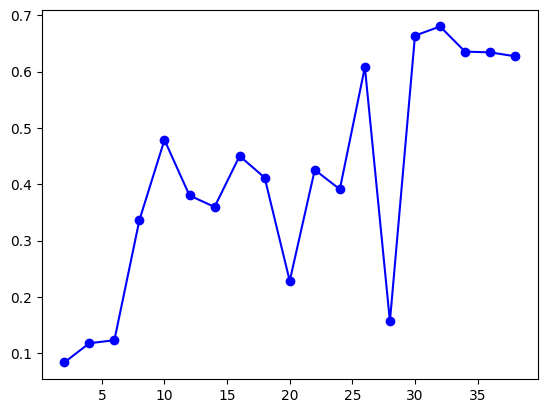

In [24]:
plt.plot(df_k_vs_score['k'], df_k_vs_score['F1_Score'], marker='o', linestyle='-', color='b')


In [41]:
selector = SelectKBest(score_func=f_classif, k=32)
selector.fit(X_train, y_train)

SelectKBest(k=32)

In [27]:
selected_columns = selector.get_support()
joblib.dump(selected_columns, 'feature_selection/k_best_selection')

['feature_selection/k_best_selection']

In [28]:
# selecting columns for X_train and X_val
X_train = X_train.iloc[:,selected_columns]
X_val = X_val.iloc[:,selected_columns]

## 7 - Training Model

### lgbm

In [29]:

final_model.fit( X_train, y_train )

y_pred_lgbm = final_model.predict( X_val )
y_proba = final_model.predict_proba( X_val )



In [30]:
result_lgbm = eveluate_model( 'lgb_model', y_val , y_pred_lgbm, y_proba )
result_lgbm

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,lgb_model,1.00,0.71,0.62,0.66,0.99


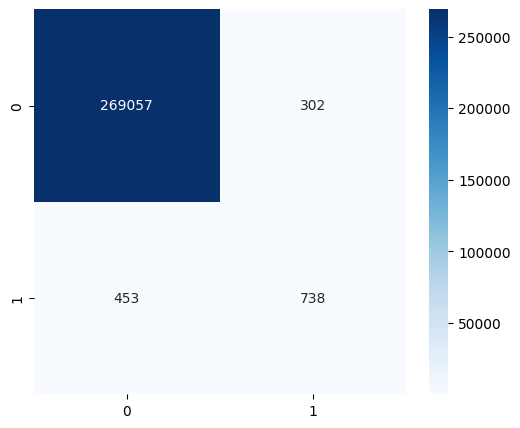

In [31]:
cm = confusion_matrix(y_val, y_pred_lgbm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')



plt.show()

## 6 - Testing on unseen data

In [48]:
X_test = df_test.loc[ (pd.to_datetime(df_test['trans_date_trans_time']) >= max_date_val ) & (pd.to_datetime(df_test['trans_date_trans_time'])<= max_date_df_test), :]
y_test = X_test['is_fraud']
X_test = X_test.drop('is_fraud', axis = 1)

print('='*100)
print(f'Test dataset:\n min date:{X_test['trans_date_trans_time'].min()} | max date :{X_test['trans_date_trans_time'].max()}')
print(f'Positive class: {y_test.value_counts()[1]:,.2f} negative class: {y_test.value_counts()[0]:,.2f} ')
print('='*100)


Test dataset:
 min date:2020-10-01 00:00:02 | max date :2020-12-31 23:59:34
Positive class: 936.00 negative class: 280,585.00 


In [49]:
X_test = feature_engineering( X_test )

In [50]:
X_test = encoding_test_data( X_test , enconding_map )

encodar como category_counts a coluna merchant
encodar como TargetEncoder a coluna category
encodar como category_counts a coluna first
encodar como category_counts a coluna last
encodar como OneHotEncoder a coluna gender
encodar como category_counts a coluna street
encodar como category_counts a coluna city
encodar como TargetEncoder a coluna state
encodar como category_counts a coluna job
encodar como TargetEncoder a coluna most_frequent_category


### Results on new data

,Model Name,Accuracy_score,Precision_score,Recall,F1_score,ROC_AUC
0,LGBMClassifier(colsample_bytree=0.676067936555...,1.00,0.48,0.70,0.57,0.85


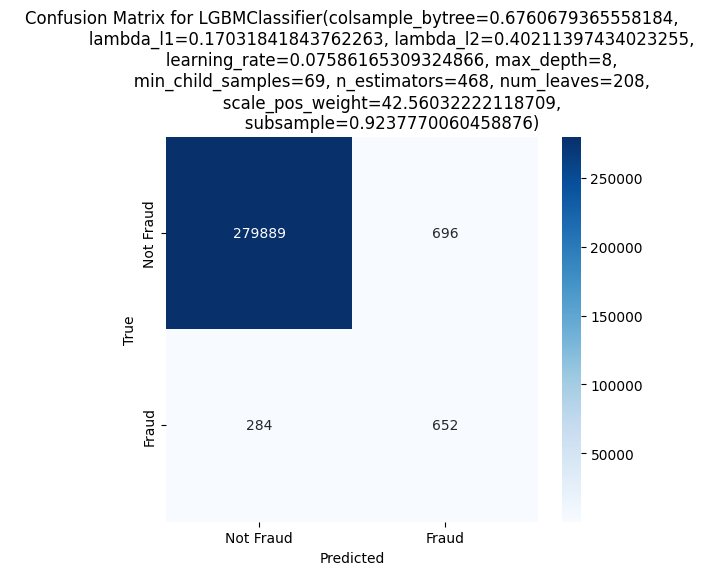

C:\Users\oscar\AppData\Local\Temp\ipykernel_8508\2056674609.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


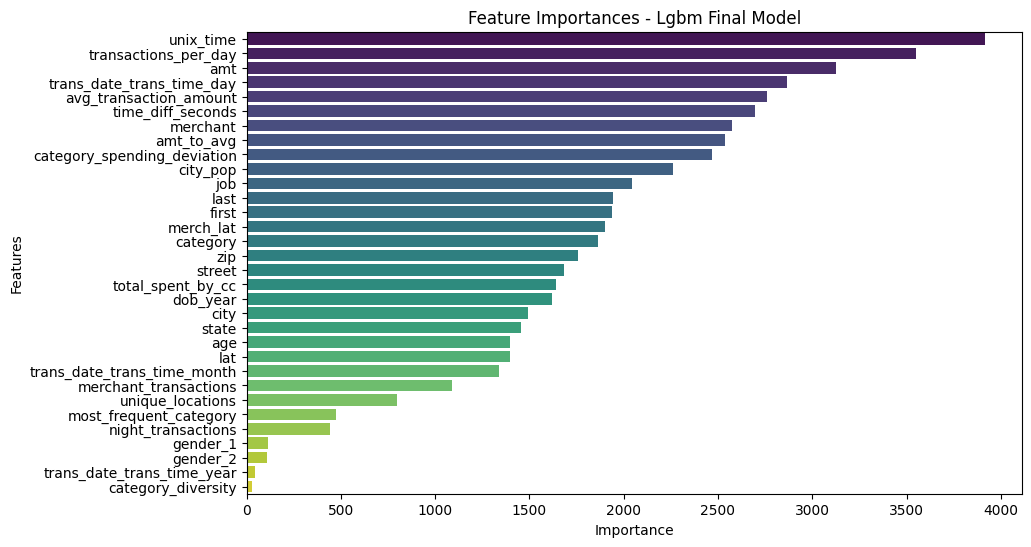

In [55]:
y_pred = final_model.predict( X_test )

y_pred_proba =  final_model.predict( X_test )

evaluation = eveluate_model( final_model, y_test ,y_pred, y_pred_proba)

display(evaluation)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title(f'Confusion Matrix for {final_model}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

importances = final_model.feature_importances_
features = X_test.columns 

  
df_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

  
df_importances = df_importances.sort_values(by='Importance', ascending=False)

 

top_features = df_importances

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Feature Importances - {'Lgbm Final Model'}')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()